In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from ipywidgets import interact, widgets

# ERP

## Source space

### Setup

In [2]:
t_min = 0
t_max = 1000
times = np.arange(t_min, t_max)  # ms
signal_frequency = 5  # Hz
other_frequency = 7

In [3]:
def make_single_trial(frequency, noise_sd = 0, random_phase=False):
    if random_phase:
        phase_shift = np.random.random() * 2 * np.pi
    else:
        phase_shift = 0
    
    period = 1000 / frequency
    data = np.sin(times * (2 * np.pi / period) + phase_shift)
    
    data += np.random.normal(scale = noise_sd, size=data.shape)
    
    return data

In [4]:
def make_trials(n_trials, *args, **kwargs):
    return np.vstack([make_single_trial(*args, **kwargs) for i in range(n_trials)])

In [5]:
def plot_trial(data, axes=None, return_line=False):
    if axes:
        plt.sca(axes)
    
    line = plt.plot(times, data)
    plt.xlim(0, 1000)

    plt.axhline(y=0, xmin=t_min, xmax=t_max)
    for x in np.arange(t_min, t_max, 1000 / signal_frequency):
        plt.axvline(x, linestyle='--')
        
    if return_line:
        return line

In [6]:
def plot_trials(data, figsize=None):
    n_trials = data.shape[0]
    nrows = np.ceil(n_trials / 5).astype(int)
    
    if not figsize:
        figsize = (15, 10 * nrows // 3)
    
    fig, axs = plt.subplots(nrows=nrows, ncols=5, figsize=figsize)
    for ax, trial in zip(axs.flat, data):
        plot_trial(trial, axes=ax)

### Phase-locked data

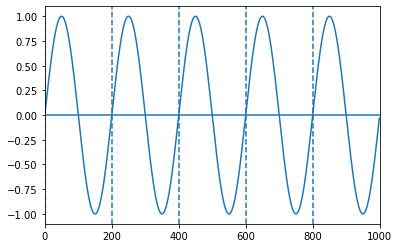

In [7]:
plot_trial(make_single_trial(signal_frequency))

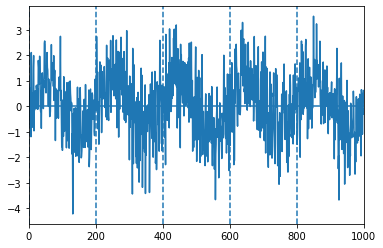

In [8]:
noise_sd = 1
plot_trial(make_single_trial(signal_frequency, noise_sd = noise_sd))

In [9]:
n_trials = 40
noise_sd = 1
signal_trials = make_trials(n_trials=n_trials, frequency=signal_frequency, noise_sd = noise_sd)

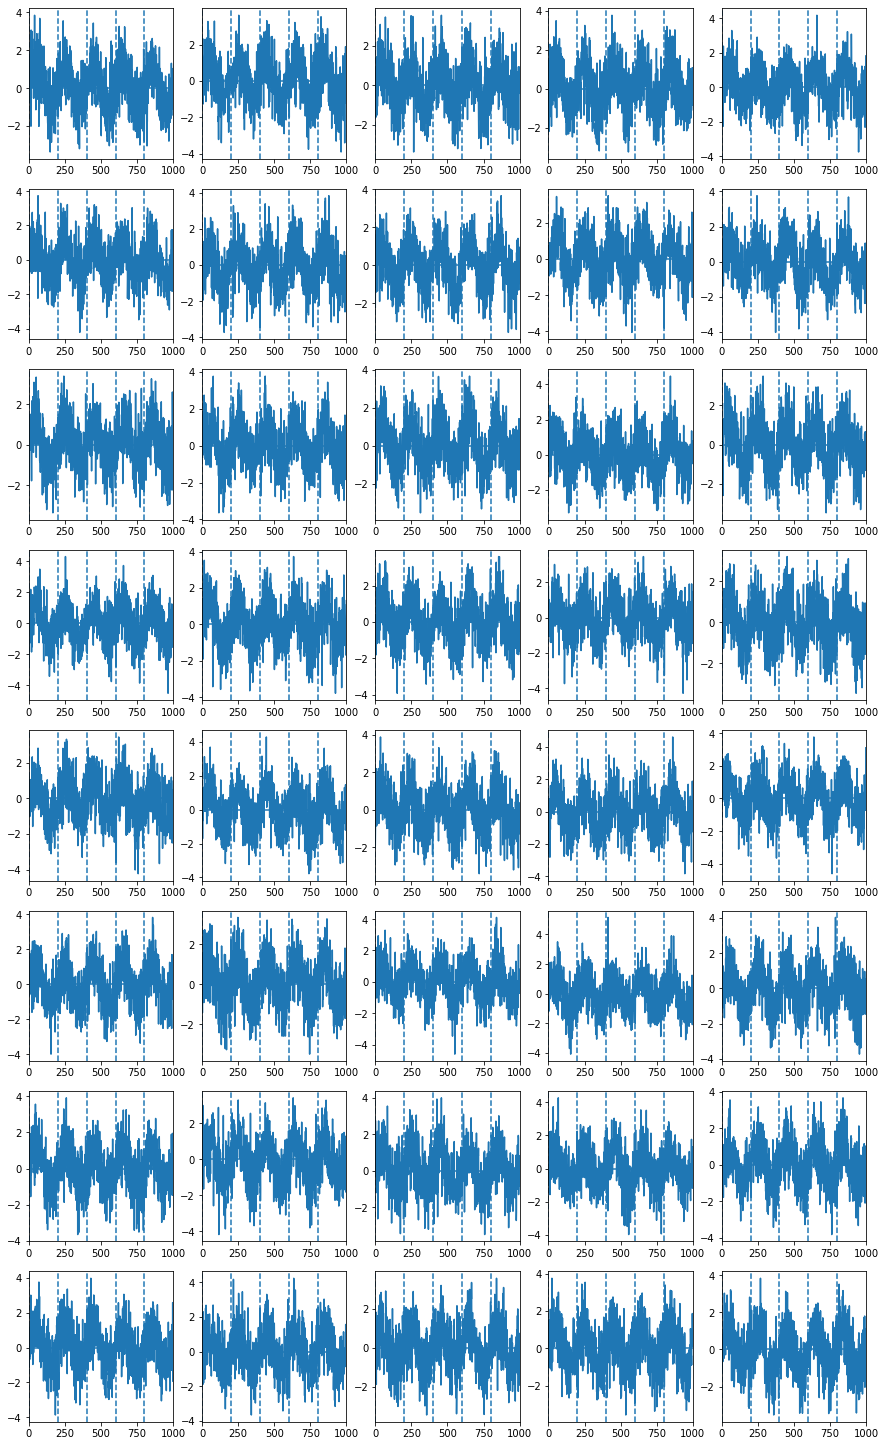

In [10]:
plot_trials(signal_trials)

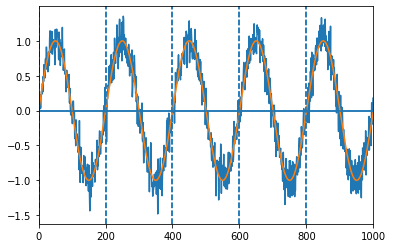

In [11]:
plot_trial(np.mean(signal_trials, axis=0))
plot_trial(make_single_trial(signal_frequency), axes=plt.gca())

### Non-phase-locked data

In [12]:
other_source_trials = make_trials(n_trials=n_trials, frequency=other_frequency, noise_sd=0, random_phase=True)

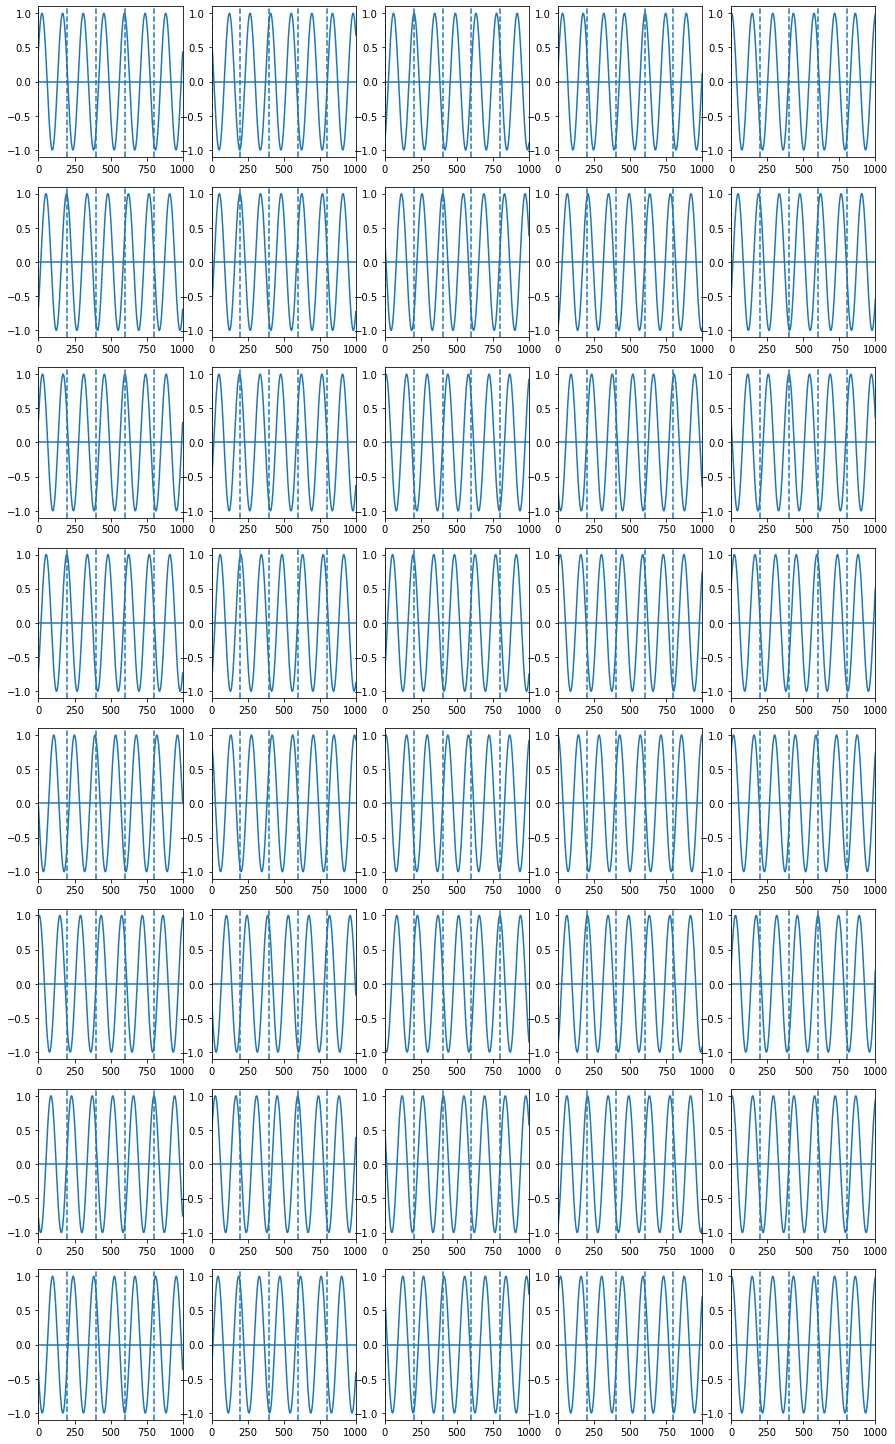

In [13]:
plot_trials(other_source_trials)

Угадайте, что будет

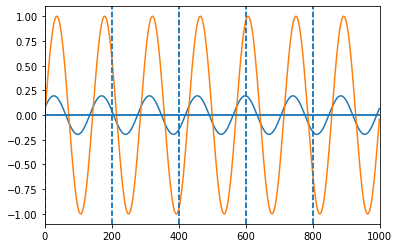

In [14]:
plot_trial(np.mean(other_source_trials, axis=0))
plot_trial(make_single_trial(other_frequency), axes=plt.gca())

In [15]:
other_source_trials = make_trials(n_trials=n_trials, frequency=other_frequency, noise_sd=noise_sd, random_phase=True)

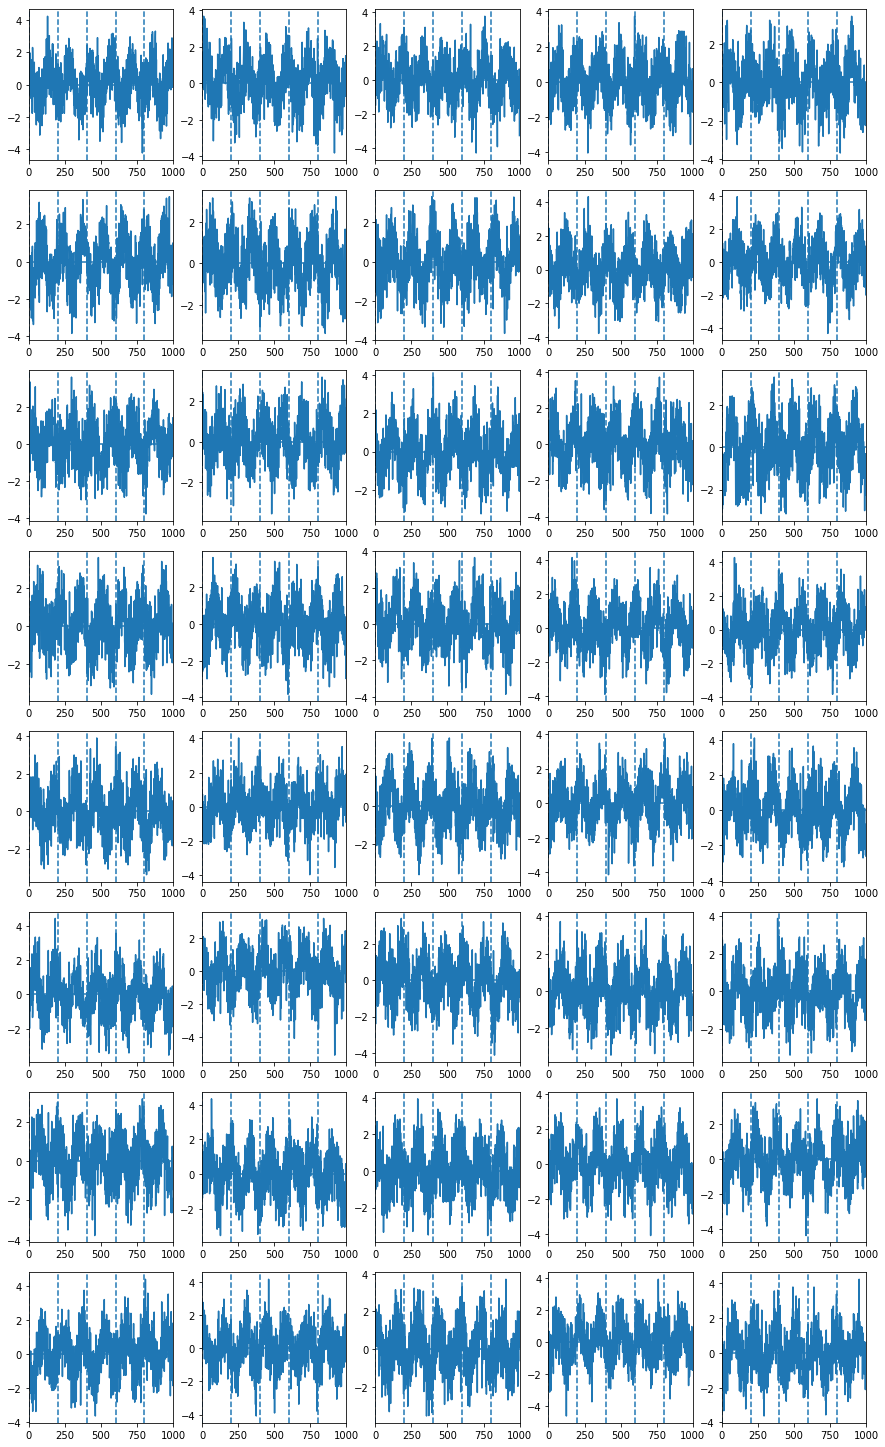

In [16]:
plot_trials(other_source_trials)

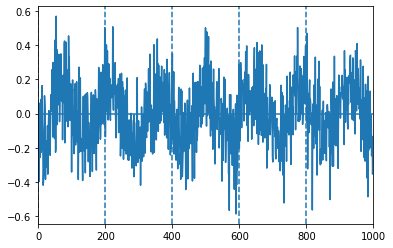

In [17]:
plot_trial(np.mean(other_source_trials, axis=0))

### Both

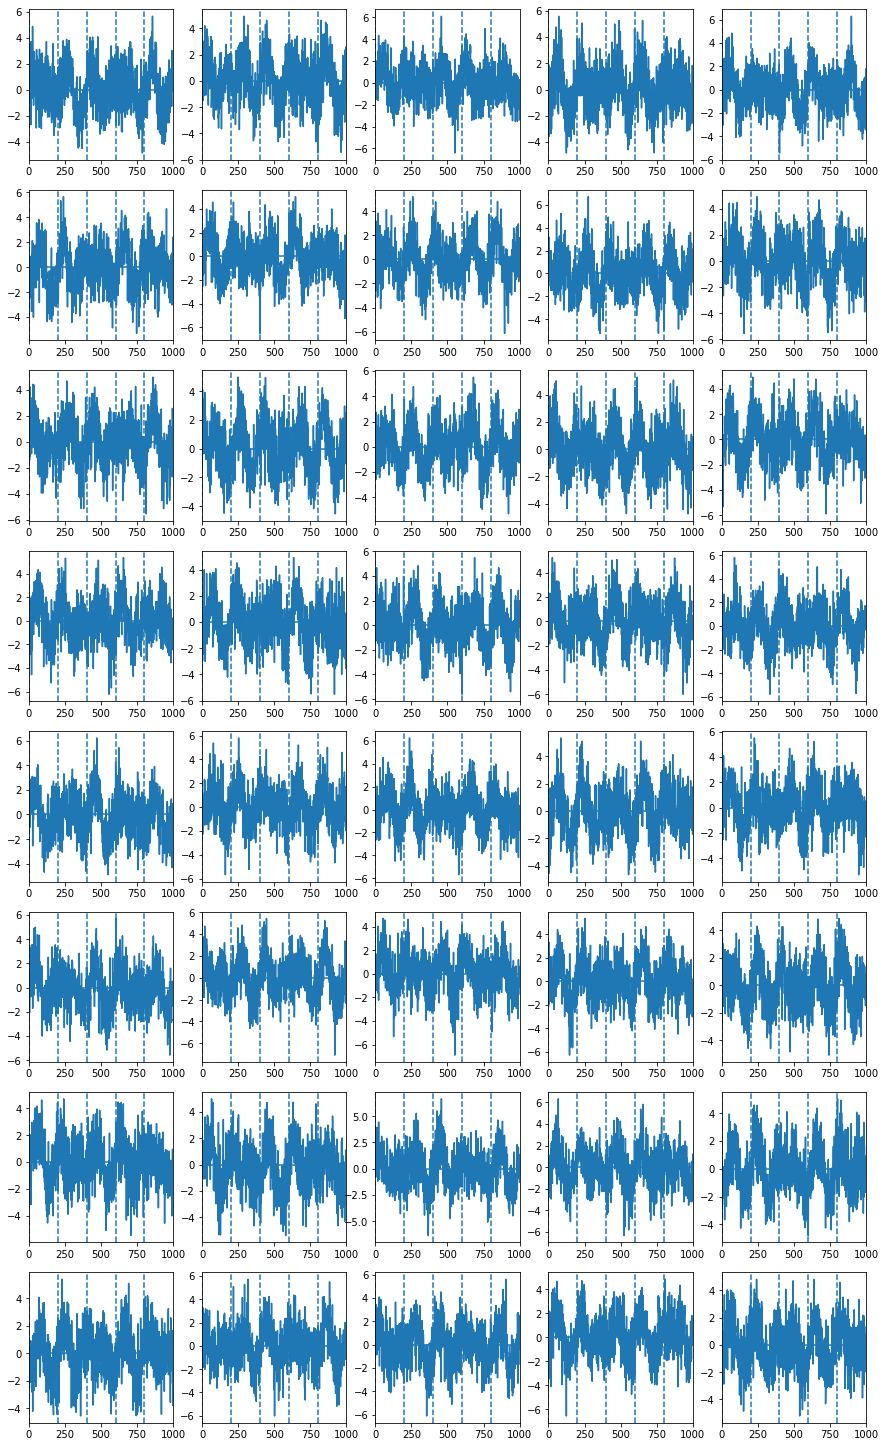

In [18]:
plot_trials(signal_trials + other_source_trials)

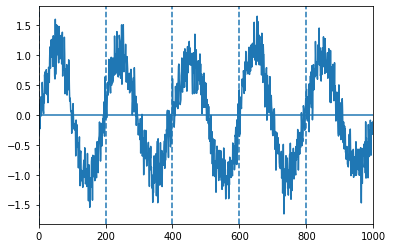

In [19]:
plot_trial(np.mean(signal_trials + other_source_trials, axis=0))
# plot_trial(make_single_trial(), axes=plt.gca())

## Sensor space

### Single channel, variable SNR

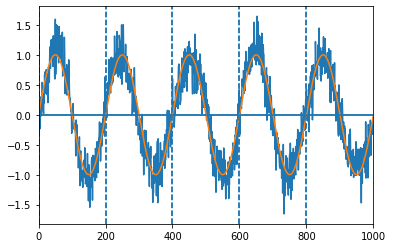

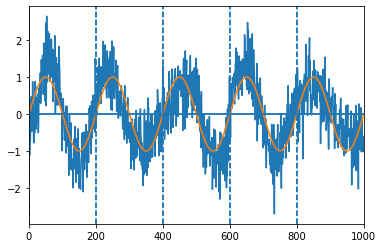

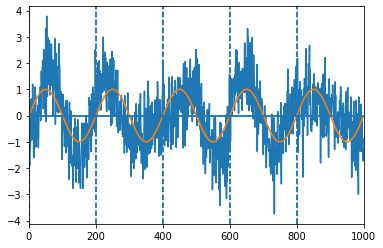

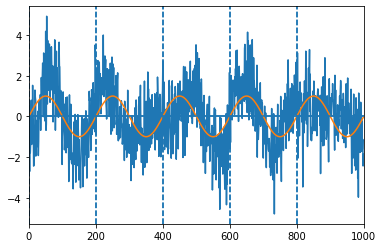

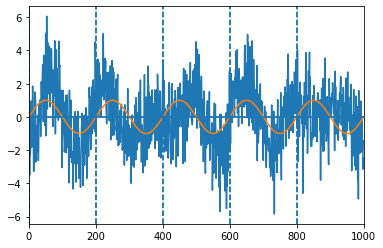

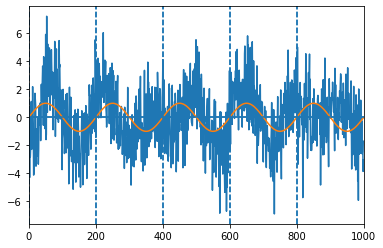

In [20]:
for i in range(1, 12, 2):
    plot_trial(np.mean(signal_trials + i * other_source_trials, axis=0))
    plot_trial(make_single_trial(signal_frequency), axes=plt.gca())
    plt.show()

### Two channels

In [21]:
def make_sensor_data(source_data, topography, sensor_noise_sd=1):
    sensor_data = source_data[..., None] * topography
    sensor_data += sensor_noise_sd * np.random.normal(size=sensor_data.shape, scale=sensor_noise_sd)
    
    return sensor_data

In [22]:
def plot_two_channels(sensor_data, axs=None, c=None, return_lines=False):

    if axs is None:
        _, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

    # Plot each sensor separately
    sensor_lines = [None, None]
    for channel_ind, (ax, data) in enumerate(zip(axs[1:3], sensor_data)):
        sensor_lines[channel_ind] = plot_trial(sensor_data[channel_ind], axes=ax, return_line=True)
        ax.set_title('Channel {}'.format(channel_ind + 1))
    
    # Plot sensor data against each other
    left_axes = axs[0]
    scatter = left_axes.scatter(sensor_data[0], sensor_data[1], c=c, cmap='RdBu', alpha=0.2)
    
    left_axes.spines['top'].set_visible(False)
    left_axes.spines['right'].set_visible(False)
    
    left_axes.set_xlabel(axs[1].title.get_text())
    left_axes.set_ylabel(axs[2].title.get_text())
    
    left_axes.axvline(0)
    left_axes.axhline(0)
    
    xmax = np.abs(np.array(left_axes.get_xlim())).max()
    ymax = np.abs(np.array(left_axes.get_ylim())).max()
    xymax = max(xmax, ymax)
    left_axes.set_xlim(-xymax, xymax)
    left_axes.set_ylim(-xymax, xymax)
    left_axes.set_aspect('equal')
    left_axes.grid()
    
    if return_lines:
        return (scatter, *sensor_lines)

In [23]:
signal_topography = np.array((3, 1))
other_topography = np.array((1, 3))

In [24]:
noise_sd

1

In [25]:
other_source_trials = make_trials(n_trials=n_trials, frequency=other_frequency, noise_sd=noise_sd, random_phase=True)

In [26]:
other_to_signal_ratio = 2
signal_sensor_data = make_sensor_data(signal_trials, signal_topography)
other_sensor_data = make_sensor_data(other_to_signal_ratio * other_source_trials, other_topography)

In [27]:
%matplotlib inline

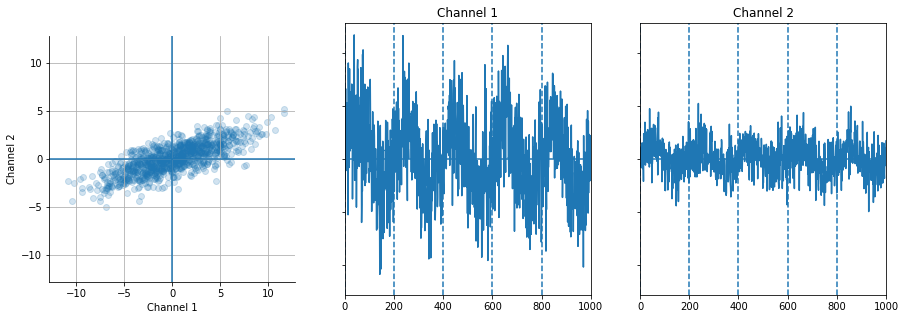

In [28]:
plot_two_channels(signal_sensor_data[0].T)

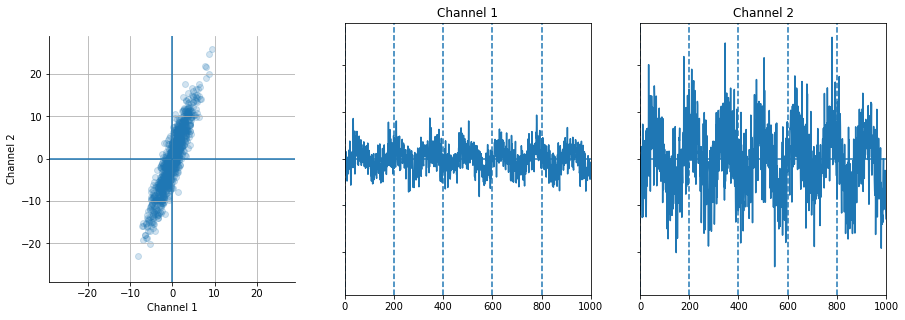

In [29]:
plot_two_channels(other_sensor_data[0].T);

In [30]:
total_sensor_data = signal_sensor_data + other_sensor_data

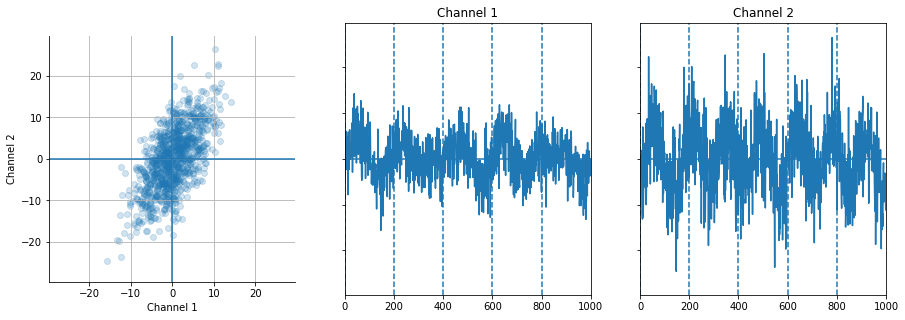

In [31]:
plot_two_channels(total_sensor_data[0].T);

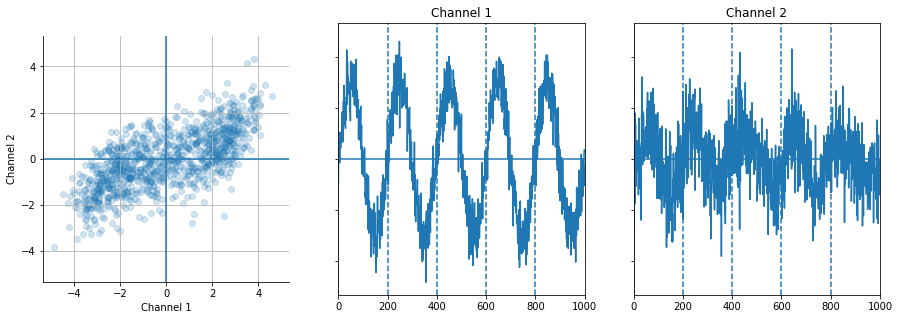

In [32]:
plot_two_channels(
    np.mean(total_sensor_data, axis=0).T
);

Добавить перпендикулярные топографии. Было бы вообще классно тогда.

# Rotation

In [33]:
def rotation_matrix(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array(((c,-s), (s, c)))

In [34]:
def rotate(theta):

    R = rotation_matrix(theta)
    rotated = total_sensor_data @ R

    rotated_trial = rotated[0]
    trial_lines[0].set_offsets(rotated[0])
    trial_lines[1][0].set_ydata(rotated_trial[:, 0])
    trial_lines[2][0].set_ydata(rotated_trial[:, 1])

    rotated_mean = np.mean(rotated, axis=0)
    mean_lines[0].set_offsets(rotated_mean)
    mean_lines[1][0].set_ydata(rotated_mean[:, 0])
    mean_lines[2][0].set_ydata(rotated_mean[:, 1])

<IPython.core.display.Javascript object>


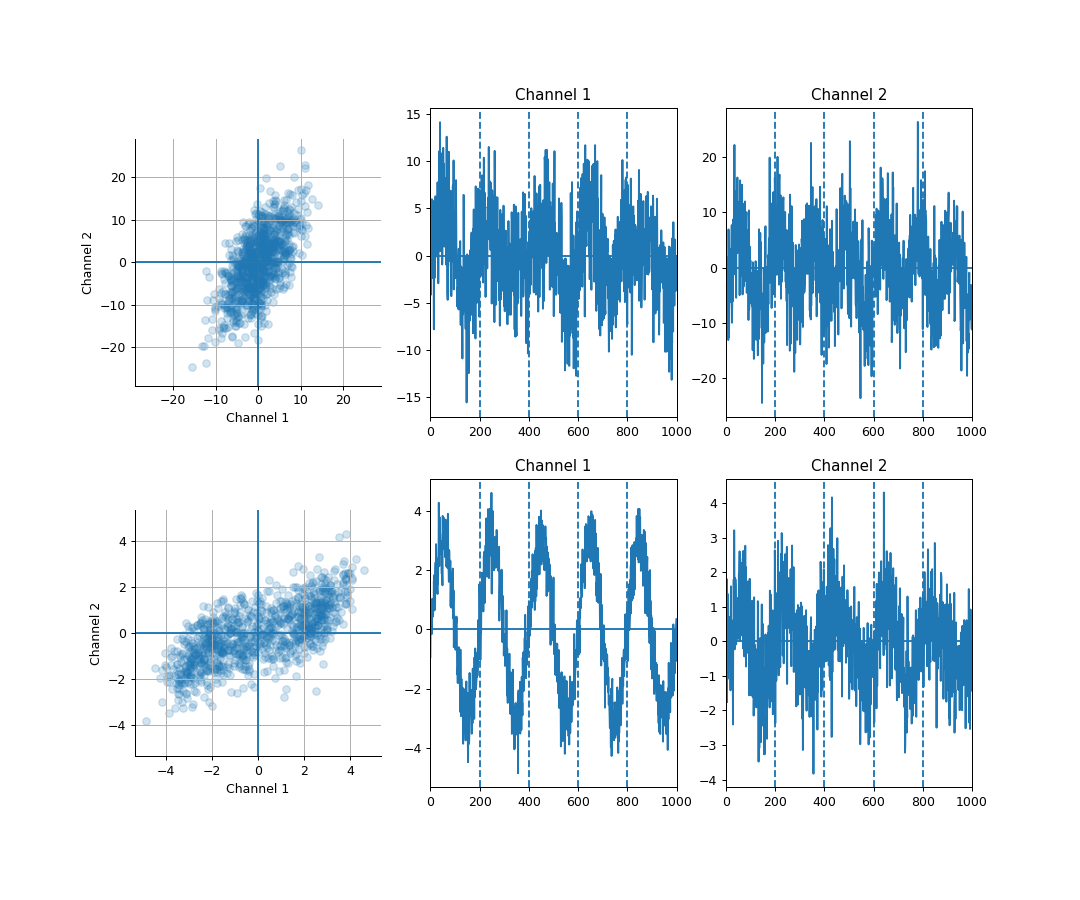

interactive(children=(FloatSlider(value=-0.0015926535897929917, description='theta', max=3.141592653589793, mi…

<function __main__.rotate(theta)>

In [49]:
%matplotlib notebook

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))
trial_lines = plot_two_channels(total_sensor_data[0].T, axs=axs[0], return_lines=True)
mean_lines = plot_two_channels(np.mean(total_sensor_data, axis=0).T, axs=axs[1], return_lines=True)

interact(rotate, theta=(-np.pi, np.pi, 0.02))

# PCA

In [36]:
erp = np.mean(total_sensor_data, axis=0).T

In [37]:
S = np.cov(erp)
L, V = np.linalg.eigh(S)

In [38]:
def rotate_2(theta):
    global arrows
    
    R = rotation_matrix(theta)
    rotated = total_sensor_data @ R

    rotated_mean = np.mean(rotated, axis=0)
    mean_lines[0].set_offsets(rotated_mean)
    mean_lines[1][0].set_ydata(rotated_mean[:, 0])
    mean_lines[2][0].set_ydata(rotated_mean[:, 1])
    
    for i in range(2):
        arrows[i].remove()
    arrows = draw_arrows(V @ R, L, axes=axs[0])

In [39]:
def draw_arrows(vectors, amplitudes, axes, facecolor='white'):
    ylim = axes.get_ylim()
    scale = ylim[1] - ylim[0]
    width, head_width, head_length = np.array((0.02, 0.02, 0.01)) * scale
    
    arrows = [None, None]
    for i, (v, l) in enumerate(zip(vectors.T, amplitudes)):
        dx, dy = np.sqrt(l) * v * np.sign(np.dot(v, signal_topography))
        arrows[i] = axes.arrow(
            x=-dx, y=-dy, dx=2 * dx, dy= 2 * dy, 
            length_includes_head=False, width = width, head_width=head_width, head_length=head_length, 
            facecolor=facecolor)
        
    return arrows

<IPython.core.display.Javascript object>


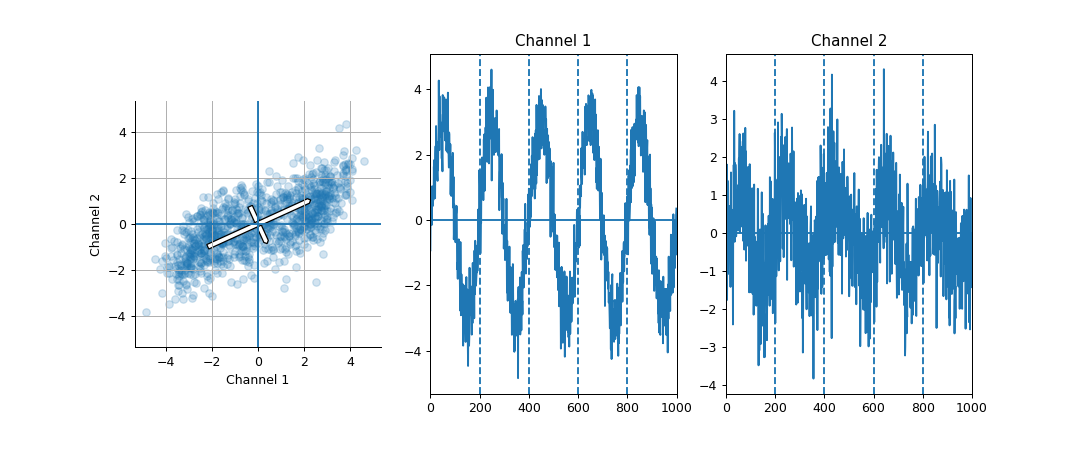

interactive(children=(FloatSlider(value=-0.0015926535897929917, description='theta', max=3.141592653589793, mi…

<function __main__.rotate_2(theta)>

In [47]:
%matplotlib notebook

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
mean_lines = plot_two_channels(np.mean(total_sensor_data, axis=0).T, axs=axs, return_lines=True)

arrows = draw_arrows(V, L, axes=axs[0])

interact(rotate_2, theta=(-np.pi, np.pi, 0.02))

# Whitening

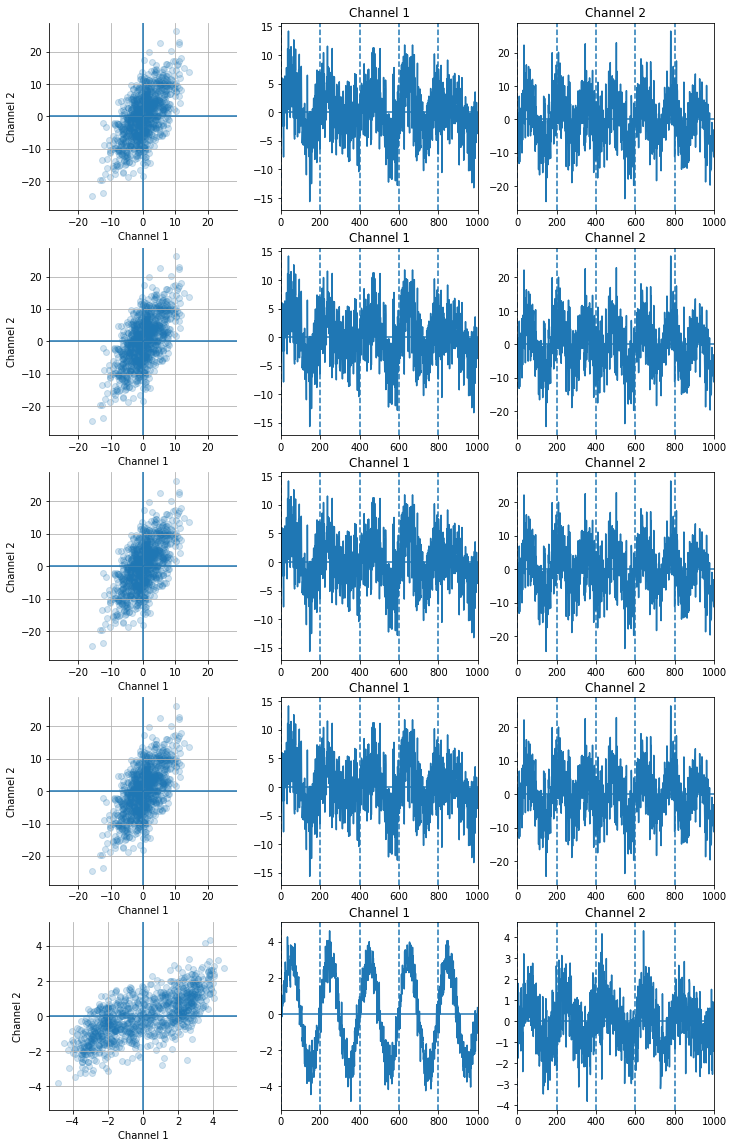

In [41]:
%matplotlib inline
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(12, 20))
for i in range(4):
    plot_two_channels(total_sensor_data[0].T, axs=axs[i], return_lines=True)

mean_lines = plot_two_channels(np.mean(total_sensor_data, axis=0).T, axs=axs[-1], return_lines=True)

In [42]:
S2 = np.mean(
    np.array(
        [np.cov(trial.T) for trial in total_sensor_data]), 
    axis=0)
L2, V2 = np.linalg.eigh(S2)

In [43]:
def rotate_normalize(theta, x):
    global arrows_1, arrows_2
    
    R3 = rotation_matrix(theta)
    normalized_L2 = (1 - x) * L2 + x * np.array((1, 1)) * L2.mean()
    normalized_rotated = total_sensor_data @ R3 * np.sqrt(normalized_L2 / L2)[::-1]

    normalized_rotated_trial = normalized_rotated[0]
    trial_lines[0].set_offsets(normalized_rotated_trial)
    trial_lines[1][0].set_ydata(normalized_rotated_trial[:, 0])
    trial_lines[2][0].set_ydata(normalized_rotated_trial[:, 1])
    
    
    normalized_rotated_mean = np.mean(normalized_rotated, axis=0)
    mean_lines[0].set_offsets(normalized_rotated_mean)
    mean_lines[1][0].set_ydata(normalized_rotated_mean[:, 0])
    mean_lines[2][0].set_ydata(normalized_rotated_mean[:, 1])
    
    for i in range(2):
        arrows_1[i].remove()
        arrows_2[i].remove()
    
    arrows_1 = draw_arrows(V2 @ R3, normalized_L2, axes=axs[0, 0])
    arrows_2 = draw_arrows(V2 @ R3, normalized_L2 / 5, axes=axs[1, 0])

<IPython.core.display.Javascript object>


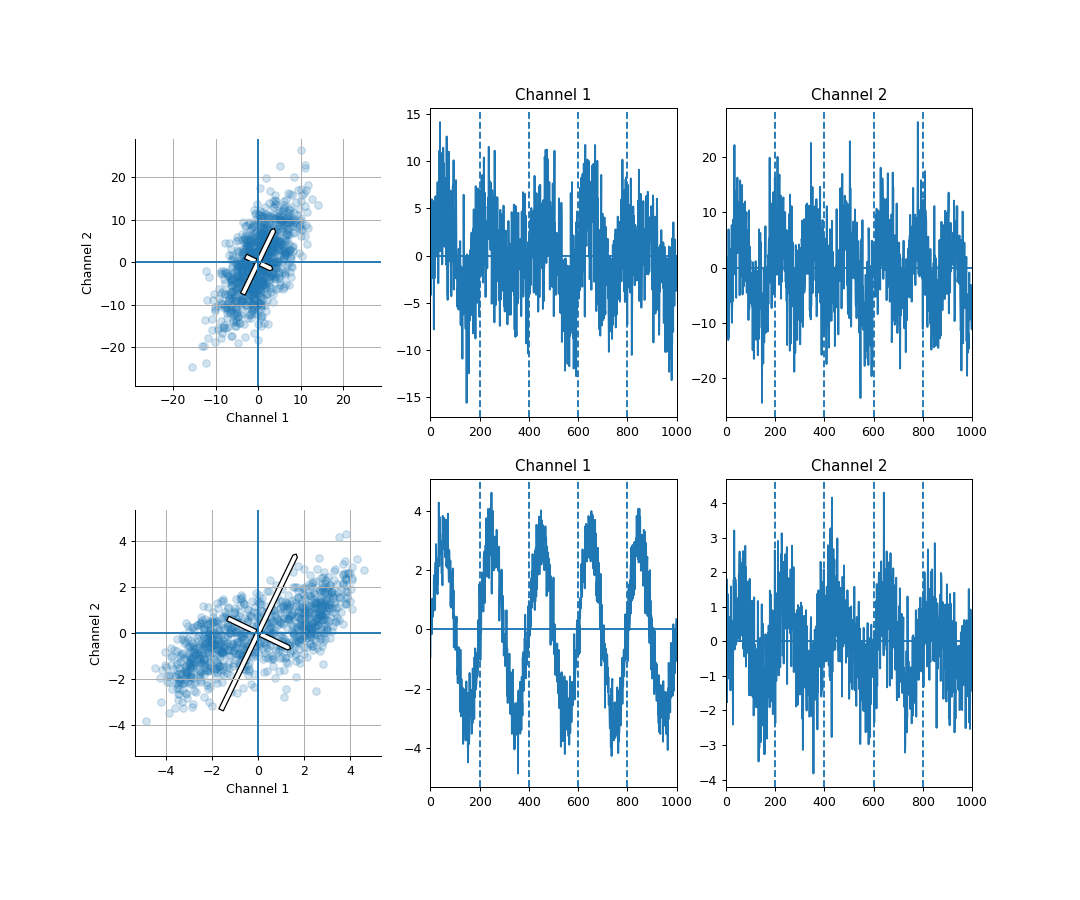

interactive(children=(FloatSlider(value=0.0, description='theta', max=1.1213986592242005, step=0.02), FloatSli…

<function __main__.rotate_normalize(theta, x)>

In [48]:
%matplotlib notebook

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))
trial_lines = plot_two_channels(total_sensor_data[0].T, axs=axs[0], return_lines=True)
mean_lines = plot_two_channels(np.mean(total_sensor_data, axis=0).T, axs=axs[1], return_lines=True)

arrows_1 = draw_arrows(V2, L2, axes=axs[0, 0])
arrows_2 = draw_arrows(V2, L2 / 5, axes=axs[1, 0])

interact(rotate_normalize, 
         theta=widgets.FloatSlider(min=0, max=np.arctan2(*V2[:, 1][::-1]), step=0.02, value=0), 
         x=widgets.FloatSlider(min=0, max=1, step=0.02, value=0))

# GED

In [45]:
def rotate_normalize_rotate(theta, x, phi):
    global arrows_1, arrows_2
    
    R3 = rotation_matrix(theta)
    normalized_L2 = (1 - x) * L2 + x * np.array((1, 1)) * L2.mean()
    normalized_rotated = total_sensor_data @ R3 * np.sqrt(normalized_L2 / L2)[::-1]

    normalized_rotated_trial = normalized_rotated[0]
    trial_lines[0].set_offsets(normalized_rotated_trial)
    trial_lines[1][0].set_ydata(normalized_rotated_trial[:, 0])
    trial_lines[2][0].set_ydata(normalized_rotated_trial[:, 1])
    
    
    R4 = rotation_matrix(phi)
    normalized_rotated_mean = np.mean(normalized_rotated, axis=0)
    rotated_normalized_rotated_mean = normalized_rotated_mean @ R4
    mean_lines[0].set_offsets(rotated_normalized_rotated_mean)
    mean_lines[1][0].set_ydata(rotated_normalized_rotated_mean[:, 0])
    mean_lines[2][0].set_ydata(rotated_normalized_rotated_mean[:, 1])
    
    for i in range(2):
        arrows_1[i].remove()
        arrows_2[i].remove()
    
    S3 = np.cov(normalized_rotated_mean.T)
    L3, V3 = np.linalg.eigh(S3)
    
    arrows_1 = draw_arrows(V2 @ R3, normalized_L2, axes=axs[0, 0])
    arrows_2 = draw_arrows(V3 @ R4, L3, axes=axs[1, 0])

<IPython.core.display.Javascript object>


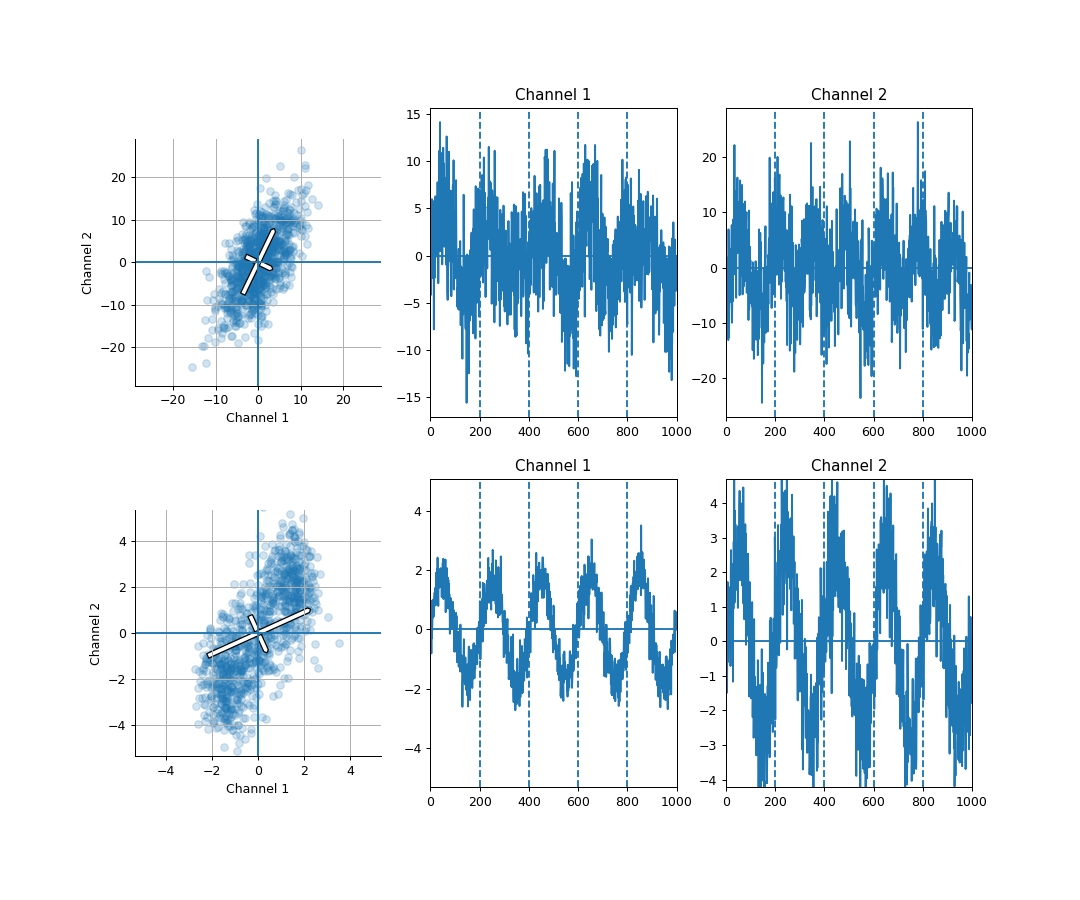

interactive(children=(FloatSlider(value=0.0, description='theta', max=1.1213986592242005, step=0.02), FloatSli…

<function __main__.rotate_normalize_rotate(theta, x, phi)>

In [46]:
%matplotlib notebook

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))
trial_lines = plot_two_channels(total_sensor_data[0].T, axs=axs[0], return_lines=True)
mean_lines = plot_two_channels(np.mean(total_sensor_data, axis=0).T, axs=axs[1], return_lines=True)

arrows_1 = draw_arrows(V2, L2, axes=axs[0, 0])
arrows_2 = draw_arrows(V2, L2 / 5, axes=axs[1, 0])  # it does not matter what we draw here

interact(rotate_normalize_rotate, 
         theta=widgets.FloatSlider(min=0, max=np.arctan2(*V2[:, 1][::-1]), step=0.02, value=0), 
         x=widgets.FloatSlider(min=0, max=1, step=0.02, value=0),
         phi=widgets.FloatSlider(min=-np.pi, max=np.pi, step=0.02, value=0))